In [28]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
pd.options.display.max_rows = 1000

# 1. Extract station names from Wikipedia

In [7]:
# Fetch the HTML content from the URL
load_from_saved = True
file_name = 'beijing_metro_stations_wikipedia_html.txt'

if not load_from_saved:
    response = requests.get("https://en.wikipedia.org/wiki/List_of_Beijing_Subway_stations")
    print(f"HTML length: {len(response.text)}, sample: {response.text[:10]}")
    response_text = response.text

    # Save response text to a text file
    file_name = 'beijing_metro_stations_wikipedia_html.txt'
    with open(file_name, "w", encoding="utf-8") as file:
        file.write(response_text)

# Read the string back into a new variable
with open(file_name, "r", encoding="utf-8") as file:
    response_text = file.read()

# Parse the HTML content
soup = BeautifulSoup(response_text, 'html.parser')

# Find all tables in the page
tables = soup.find_all('table')
print(f'# tables: {len(tables)}')

# tables: 36


In [8]:
def extract_first_number(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    return 99

stations_remove = ['53号']

# Loop through each table
dict_stations = defaultdict(list)
for table in tables:
    headers = table.find_all('th')
    header_texts = [header.get_text(strip=True) for header in headers]
    
    # Check if "Chinese-language text" is one of the column headers
    if "Chinese name" in header_texts and "Station" in header_texts:
        chinese_col_index = header_texts.index("Chinese name")
        english_index = header_texts.index("Station")
        line_number = extract_first_number(table.caption.get_text())
        
        # Find all rows in the table body
        rows = table.find_all('tr')
        for i_row, row in enumerate(rows[1:]):  # Skip header row
            cells = row.find_all(['td', 'th'])  # Sometimes headers repeat in body
            if len(cells) > chinese_col_index:
                chinese_text = cells[chinese_col_index].get_text(strip=True)
                english_text = cells[english_index].get_text(strip=True)
                if chinese_text not in stations_remove:
                    dict_stations['chinese'].append(chinese_text)
                    dict_stations['english'].append(chinese_text)
                    dict_stations['line_number'].append(line_number)
                    dict_stations['station_number'].append(i_row)

df_stations = pd.DataFrame(dict_stations)

print(f'# stations: {len(df_stations)}')
df_stations.head()

# stations: 521


,chinese,english,line_number,station_number
0,福寿岭,福寿岭,1,1
1,苹果园,苹果园,1,2
2,古城,古城,1,3
3,八角游乐园,八角游乐园,1,4
4,八宝山,八宝山,1,5


# 2. Process data and get character counts

In [24]:
# Remove all parentheses and numbers using regex
def remove_parentheses_and_numbers(s):
    return re.sub(r'[0-9()\[\]]+', '', s)

all_char = ''.join(df_stations['chinese'].values)
all_char = list(remove_parentheses_and_numbers(all_char))

# Get counts of all characters
char_counts = pd.Series(all_char).value_counts().reset_index().rename(columns={"index": 'char'})
print(char_counts.head(10))
print(len(char_counts), char_counts['count'].sum())

  char  count
0    桥     56
1    门     53
2    西     49
3    庄     47
4    东     43
5    北     42
6    园     35
7    路     31
8    大     31
9    南     28
399 1658


# 3. get pinyin

In [ ]:
def load_pinyin_dict(filename):
    pinyin_dict = {}

    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()

            # Skip empty lines or comments
            if not line or line.startswith("#"):
                continue

            # Split line at '#' to separate the Chinese character
            parts = line.split("#")
            if len(parts) < 2:
                continue

            chinese_char = parts[1].strip()  # e.g., 㐀

            # Split left side at ':' to get Pinyin
            left_part = parts[0].split(":")
            if len(left_part) < 2:
                continue

            pinyin = left_part[1].strip()  # e.g., qiū

            # Add to dictionary
            pinyin_dict[chinese_char] = pinyin

    return pinyin_dict

# Downloaded file from https://github.com/mozillazg/pinyin-data/blob/27dc54a206326e0d8d91428010325f50f614508d/pinyin.txt
char_to_pinyin_dict = load_pinyin_dict("pinyin.txt")
print(char_to_pinyin_dict['㐀'])  # Output: qiū

qiū


In [27]:
def get_example_stations(char, n_examples=3):
    return list(df_stations[df_stations['chinese'].str.contains(char)].head(n_examples)['chinese'].values)

char_counts['pinyin_all'] = char_counts['char'].map(char_to_pinyin_dict)
char_counts['pinyin'] = char_counts['pinyin_all'].apply(lambda x: str(x).split(',')[0])
char_counts['char_pinyin'] = char_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)
char_counts['examples'] = char_counts['char'].apply(get_example_stations)
char_counts.head(10)

,char,count,pinyin_all,pinyin,char_pinyin,examples
0,桥,56,qiáo,qiáo,qiáo 桥,"[双桥, 八里桥, 土桥]"
1,门,53,mén,mén,mén 门,"[复兴门, 天安门西, 天安门东]"
2,西,49,xī,xī,xī 西,"[西单, 天安门西, 西直门]"
3,庄,47,"zhuāng,péng",zhuāng,zhuāng 庄,"[管庄, 花庄, 车公庄]"
4,东,43,dōng,dōng,dōng 东,"[天安门东, 东单, 四惠东]"
5,北,42,"běi,bèi",běi,běi 北,"[通州北苑, 北京站, 安河桥北]"
6,园,35,"yuán,wán",yuán,yuán 园,"[苹果园, 八角游乐园, 果园]"
7,路,31,"lù,luò",lù,lù 路,"[玉泉路, 万寿路, 南礼士路]"
8,大,31,"dà,dài,tài",dà,dà 大,"[大望路, 传媒大学, 鼓楼大街]"
9,南,28,"nán,nā",nán,nán 南,"[南礼士路, 北京南站, 高米店南]"


# 4. plot character frequency

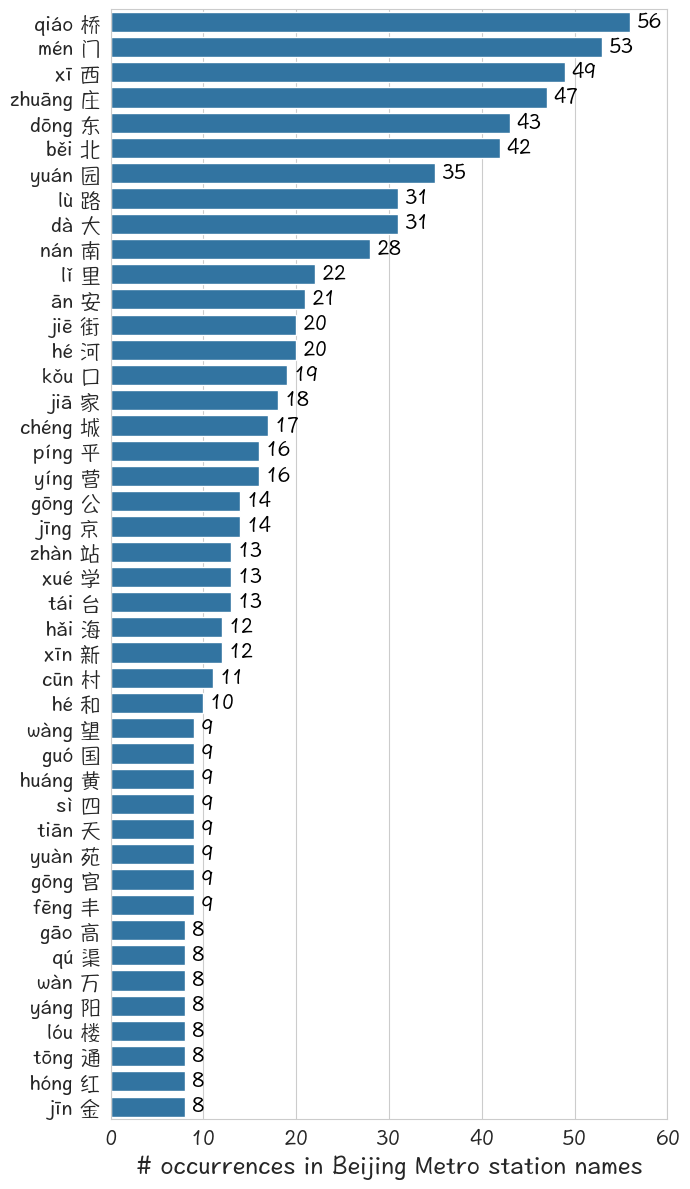

In [32]:
df_plt = char_counts[char_counts['count'] > 7]

# Plot bars
xaxis_limit = 60
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,12))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Beijing Metro station names', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./character_rankings_beijing.png')
